필요한 Library

In [3]:
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import to_networkx
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

Cora Dataset

In [4]:
dataset = Planetoid(root='.', name="cora")
data = dataset[0]

Graph 구조와 특징

In [5]:
# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Training nodes: {sum(data.train_mask).item()}')
print(f'Evaluation nodes: {sum(data.val_mask).item()}')
print(f'Test nodes: {sum(data.test_mask).item()}')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Dataset: cora()
-------------------
Number of graphs: 1
Number of nodes: 2708
Number of features: 1433
Number of classes: 7

Graph:
------
Training nodes: 140
Evaluation nodes: 500
Test nodes: 1000
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


Minibatch 생성


Minibatch란 대용량의 Graph를 나누어 학습하기 위해 나온 것으로
학습할 노드들을 랜덤하게 선택하여 하나의 Minibatch를 생성

본 데이터 셋은 데이터의 양이 적어 Full-batch로 진행

In [12]:
# Create batches with neighbor sampling
train_loader = NeighborLoader(
    data,
    num_neighbors=[5,5],
    batch_size=140,
    input_nodes=data.train_mask,
)

생성된 Minibatch의 설명

In [13]:
# Print each subgraph
for i, subgraph in enumerate(train_loader):
    print(f'Subgraph {i}: {subgraph}')

Subgraph 0: Data(x=[1029, 1433], edge_index=[2, 1939], y=[1029], train_mask=[1029], val_mask=[1029], test_mask=[1029], n_id=[1029], e_id=[1939], input_id=[140], batch_size=140)


Minibatch 시각화

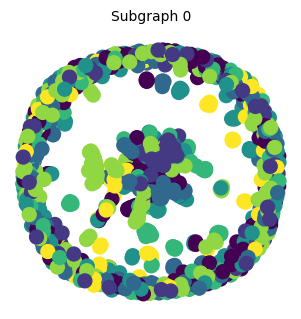

In [14]:
# Plot each subgraph
fig = plt.figure(figsize=(8,8))
for idx, (subdata, pos) in enumerate(zip(train_loader, [221, 222, 223, 224])):
    G = to_networkx(subdata, to_undirected=True)
    ax = fig.add_subplot(pos)
    ax.set_title(f'Subgraph {idx}', fontsize=10)
    plt.axis('off')
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_color=subdata.y,
                    node_size = 100
                    )
plt.show()

In [15]:
import torch
torch.manual_seed(-1)
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

GraphSAGE 모델 구현

In [16]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.sage1 = SAGEConv(dim_in, dim_h) # default = mean aggregator
        self.sage2 = SAGEConv(dim_h, dim_out)

    def forward(self, x, edge_index):
        h = self.sage1(x, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.sage2(h, edge_index)
        h = F.log_softmax(h, dim=1)
        return h

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)

        self.train()
        for epoch in range(epochs+1):
            total_loss = 0
            acc = 0
            val_loss = 0
            val_acc = 0
            # Train on batches
            for batch in train_loader:
                optimizer.zero_grad()
                out = self(batch.x, batch.edge_index)
                loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
                total_loss += loss.item()
                acc += accuracy(out[batch.train_mask].argmax(dim=1), batch.y[batch.train_mask])
                loss.backward()
                optimizer.step()

                # Validation
                val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
                val_acc += accuracy(out[batch.val_mask].argmax(dim=1), batch.y[batch.val_mask])
                print(f'Batch : {batch}')
            # Print metrics every 10 epochs
            #if epoch % 20 == 0:
            print(f'Epoch {epoch:>3} | Train Loss: {loss/len(train_loader):.3f} | Train Acc: {acc/len(train_loader)*100:>6.2f}% | Val Loss: {val_loss/len(train_loader):.2f} | Val Acc: {val_acc/len(train_loader)*100:.2f}%')


    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

def accuracy(pred_y, y):
    return ((pred_y == y).sum() / len(y)).item()

200번의 학습 (Epoch)을 통해

정확도: 77.9% 를 얻음

In [17]:
# Create GraphSAGE
graphsage = GraphSAGE(dataset.num_features, 64, dataset.num_classes)
print(graphsage)

# Train
graphsage.fit(data, 200)

# Test
acc = graphsage.test(data)
print(f'GraphSAGE test accuracy: {acc*100:.2f}%')

GraphSAGE(
  (sage1): SAGEConv(1433, 64, aggr=mean)
  (sage2): SAGEConv(64, 7, aggr=mean)
)
Batch : Data(x=[1057, 1433], edge_index=[2, 1949], y=[1057], train_mask=[1057], val_mask=[1057], test_mask=[1057], n_id=[1057], e_id=[1949], input_id=[140], batch_size=140)
Epoch   0 | Train Loss: 1.957 | Train Acc:  13.57% | Val Loss: 1.93 | Val Acc: 22.10%
Batch : Data(x=[1052, 1433], edge_index=[2, 1935], y=[1052], train_mask=[1052], val_mask=[1052], test_mask=[1052], n_id=[1052], e_id=[1935], input_id=[140], batch_size=140)
Epoch   1 | Train Loss: 1.675 | Train Acc:  82.14% | Val Loss: 1.88 | Val Acc: 33.33%
Batch : Data(x=[1037, 1433], edge_index=[2, 1939], y=[1037], train_mask=[1037], val_mask=[1037], test_mask=[1037], n_id=[1037], e_id=[1939], input_id=[140], batch_size=140)
Epoch   2 | Train Loss: 1.269 | Train Acc:  96.43% | Val Loss: 1.77 | Val Acc: 49.72%
Batch : Data(x=[1042, 1433], edge_index=[2, 1917], y=[1042], train_mask=[1042], val_mask=[1042], test_mask=[1042], n_id=[1042], e_i